##Install dependencies

In [0]:
!pip install --upgrade fastai

##Download & unzip data

In [20]:
import zipfile
!wget "https://he-s3.s3.amazonaws.com/media/hackathon/hackerearth-deep-learning-challenge-auto-tag-images-gala/auto-tag-images-of-the-gala-9e47fb31/9d34462453e311ea.zip"
with zipfile.ZipFile("9d34462453e311ea.zip","r") as zip_ref:
    zip_ref.extractall("")

--2020-04-06 20:48:29--  https://he-s3.s3.amazonaws.com/media/hackathon/hackerearth-deep-learning-challenge-auto-tag-images-gala/auto-tag-images-of-the-gala-9e47fb31/9d34462453e311ea.zip
Resolving he-s3.s3.amazonaws.com (he-s3.s3.amazonaws.com)... 52.219.128.76
Connecting to he-s3.s3.amazonaws.com (he-s3.s3.amazonaws.com)|52.219.128.76|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 30062440 (29M) [application/zip]
Saving to: ‘9d34462453e311ea.zip.1’

9d34462453e311ea.zi 100%[===================>]  28.67M  33.0MB/s    in 0.9s    

2020-04-06 20:48:30 (33.0 MB/s) - ‘9d34462453e311ea.zip.1’ saved [30062440/30062440]



# Read Dataset

In [21]:
from fastai.vision import *
np.random.seed(123)
path = Path("dataset")
labels = pd.read_csv(path/"train.csv")
test_df=pd.read_csv(path/"test.csv")
labels.head()

,Image,Class
0,image7042.jpg,Food
1,image3327.jpg,misc
2,image10335.jpg,Attire
3,image8019.jpg,Food
4,image2128.jpg,Attire


In [22]:
print(labels["Class"].nunique()); classes = list(set(labels["Class"])); classes

4


['Food', 'Attire', 'Decorationandsignage', 'misc']

In [23]:
for i in classes:
    print("Number of items in class {} is {}".format(i,len(labels[labels["Class"] == i])))

Number of items in class Food is 2278
Number of items in class Attire is 1691
Number of items in class Decorationandsignage is 743
Number of items in class misc is 1271


In [0]:
tfms = get_transforms(do_flip=True,
                      flip_vert=False,
                      
                      max_rotate=10.0,
                      max_zoom=1.1,
                      max_warp=0.2,
                      max_lighting=0.2,
                      p_lighting=0.75,
                      
                      xtra_tfms=None
                     )

In [0]:

sz = 128
test_data = ImageList.from_csv(path,'test.csv', folder='Test Images', suffix='')
data_resnet50 = (ImageList.from_csv(path, 'train.csv', folder='Train Images', suffix='')
        .split_by_rand_pct()
        .label_from_df(label_delim=',') 
        .transform(tfms, size=sz)
        .databunch())                          

data.add_test(test_data)

In [0]:

sz = 150
test_data = ImageList.from_csv(path,'test.csv', folder='Test Images', suffix='')
data_resnet101 = (ImageList.from_csv(path, 'train.csv', folder='Train Images', suffix='')
        .split_by_rand_pct()
        .label_from_df(label_delim=',') 
        .transform(tfms, size=sz)
        .databunch())                          

data.add_test(test_data)

In [0]:

sz = 128
test_data = ImageList.from_csv(path,'test.csv', folder='Test Images', suffix='')
data_densen121 = (ImageList.from_csv(path, 'train.csv', folder='Train Images', suffix='')
        .split_by_rand_pct()
        .label_from_df(label_delim=',') 
        .transform(tfms, size=sz)
        .databunch())                          

data.add_test(test_data)

In [0]:

sz = 128
test_data = ImageList.from_csv(path,'test.csv', folder='Test Images', suffix='')
data_vgg = (ImageList.from_csv(path, 'train.csv', folder='Train Images', suffix='')
        .split_by_rand_pct()
        .label_from_df(label_delim=',') 
        .transform(tfms, size=sz)
        .databunch())                          

data.add_test(test_data)

In [78]:
print(data.classes); data.c

['Attire', 'Decorationandsignage', 'Food', 'misc']


4

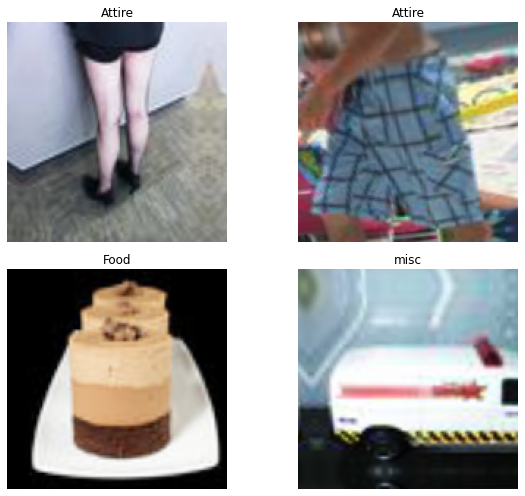

In [79]:
data.show_batch(rows=2, figsize=(9,7))

# Define Model

In [0]:
acc_02 = partial(accuracy_thresh, thresh=0.2)
f_score = partial(fbeta, thresh=0.2, beta = 1)

In [0]:
def train(arch,data,number_epochs):
 

    #define learner
    learn = cnn_learner(data, arch, metrics=[acc_02,f_score])

    #train
    learn.fit_one_cycle(number_epochs,max_lr=slice(1e-04,1e-03))
    
    return learn

# Train model

In [0]:
resnet50_learner = train(models.resnet50,data_resnet50,25)
resnet101_learner = train(models.resnet101,data_resnet101,25)
densenet121_learner = train(models.densenet121,data_densen121,25)
vgg19_learner = train(models.vgg19_bn,data_vgg,25)


epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.791612,0.536906,0.514632,0.522157,00:30
1,0.685993,0.450988,0.591137,0.572966,00:30
2,0.590908,0.402139,0.656354,0.618729,00:30
3,0.492187,0.335654,0.731814,0.677536,00:30
4,0.405979,0.275940,0.815008,0.754822,00:30
5,0.329231,0.238988,0.866848,0.801756,00:30
6,0.286593,0.218977,0.884615,0.825111,00:30
7,0.256812,0.218073,0.889005,0.826366,00:30
8,0.235571,0.205471,0.893813,0.833333,00:30
9,0.212755,0.206147,0.899038,0.838629,00:30


epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.771785,0.536873,0.532609,0.526226,01:16
1,0.652772,0.462689,0.612249,0.582664,01:16
2,0.554941,0.398082,0.689799,0.641862,01:15
3,0.449291,0.336837,0.774247,0.715552,01:16
4,0.356827,0.267204,0.849498,0.789855,01:15
5,0.294634,0.237983,0.875418,0.811037,01:16
6,0.249151,0.225268,0.881689,0.819259,01:15
7,0.219305,0.218742,0.896948,0.837096,01:16
8,0.195386,0.219491,0.896112,0.833055,01:16
9,0.182126,0.211049,0.895694,0.835563,01:16


In [0]:
import os
try:
  os.stat('dataset/models')
except:
  os.mkdir('dataset/models')
resnet50_learner.export(file = Path("models/resnet50_learner.pkl"))
resnet101_learner.export(file = Path("models/resnet101_learner.pkl"))
densenet121_learner.export(file = Path("models/densenet121_learner.pkl"))
vgg19_learner.export(file = Path("models/vgg19_learner.pkl"))

In [0]:
train_models=[resnet50_learner,resnet101_learner,densenet121_learner,vgg19_learner]

In [0]:
interp = ClassificationInterpretation.from_learner(train_models[0])
interp1 = ClassificationInterpretation.from_learner(train_models[1])
interp2 = ClassificationInterpretation.from_learner(train_models[2])
interp3 = ClassificationInterpretation.from_learner(train_models[3])


In [0]:
interp.plot_confusion_matrix()
interp1.plot_confusion_matrix()
interp2.plot_confusion_matrix()
interp3.plot_confusion_matrix()

# Predict & Submiaaion

###**Ensemble: Averaging**

In [0]:
preds, prob = train_models[0].get_preds(ds_type=DatasetType.Test)
sum_pred=preds
preds, prob = train_models[1].get_preds(ds_type=DatasetType.Test)
sum_pred+=preds
preds, prob = train_models[2].get_preds(ds_type=DatasetType.Test)
sum_pred+=preds
preds, prob = train_models[3].get_preds(ds_type=DatasetType.Test)
sum_pred+=preds

prediction = sum_pred / len(train_models)
pred_prob, pred_class = prediction.max(1)
pred=[train_models[3].data.classes[x] for x in pred_class]

## Submission

In [0]:
submission = pd.DataFrame({'Image':test_df['Image'],'Class':pred})
submission.to_csv('predictions.csv', index=False)

In [0]:
print(submission["Class"].nunique()); classes = list(set(submission["Class"])); classes
for i in classes:
    print("Number of items in class {} is {}".format(i,len(submission[submission["Class"] == i])))

In [0]:
from google.colab import drive
drive.mount('/content/drive')

In [0]:
import shutil
shutil.copy("dataset/models/resnet50_learner.pkl","drive/My Drive/Deep_Learning/models/auto_tag")
shutil.copy("dataset/models/resnet101_learner.pkl","drive/My Drive/Deep_Learning/models/auto_tag")
shutil.copy("dataset/models/densenet121_learner.pkl","drive/My Drive/Deep_Learning/models/auto_tag")
shutil.copy("dataset/models/vgg19_learner.pkl","drive/My Drive/Deep_Learning/models/auto_tag")


In [0]:
!ls
